# IREI: Profile-based retrieval
### Víctor Morcuende Castell and Guillermo Nájera Lavid
#### Course 2022-2023

### Preprocessing Phase

In [1]:
import nltk

nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /Users/victor/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/victor/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/victor/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/victor/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/victor/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to
[nltk_data]

True

In [2]:
# Read the data
import pandas as pd

train_data = pd.read_csv('dataset/BBC News Train.csv')
test_data = pd.read_csv('dataset/BBC News Test.csv')

# Transform the data into a single dataset
data = pd.concat([train_data,test_data])
data.to_csv('dataset/data.csv', index=False)
data.head(10)

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
5,1582,howard truanted to play snooker conservative...,politics
6,651,wales silent on grand slam talk rhys williams ...,sport
7,1797,french honour for director parker british film...,entertainment
8,2034,car giant hit by mercedes slump a slump in pro...,business
9,1866,fockers fuel festive film chart comedy meet th...,entertainment


In [3]:
data.shape

(2225, 3)

In [4]:
data.groupby(['Category']).size().sort_values(ascending=True)

Category
tech             408
entertainment    420
politics         421
business         483
sport            493
dtype: int64

<Axes: >

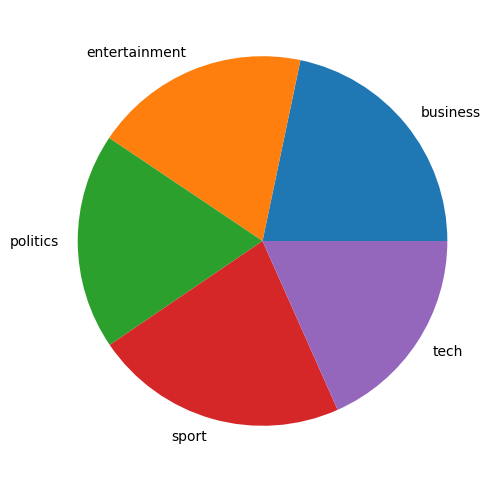

In [5]:
data.groupby(['Category']).size().plot(kind='pie', figsize=(10, 6))

<Axes: ylabel='Category'>

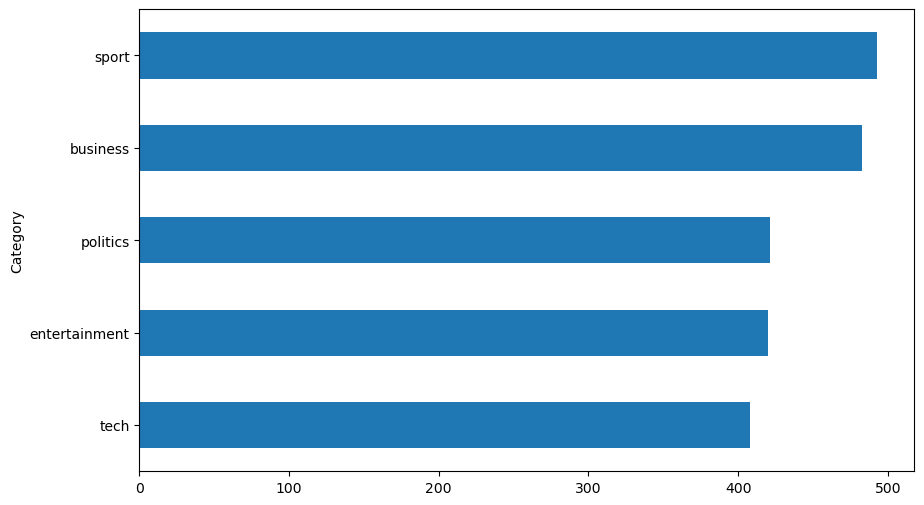

In [6]:
data.groupby(['Category']).size().sort_values(ascending=True).plot(kind='barh', figsize=(10, 6))

### Text cleaning and processing steps
* Remove punctuations
* Convert text to tokens
* Remove tokens of length less than or equal to 3
* Remove stopwords using NLTK corpus stopwords list to match
* Apply lemmatization
* Convert words to feature vectors

In [7]:
# Remove all punctuations from the text
import string as st

def remove_punct(text):
    return ("".join([ch for ch in text if ch not in st.punctuation]))

In [8]:
data['removed_punc'] = data['Text'].apply(lambda x: remove_punct(x))
data.head()

,ArticleId,Text,Category,removed_punc
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens in ...
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster bett...
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses in 168m payout eighteen former en...


In [9]:
''' Convert text to lower case tokens. Here, split() is applied on white-spaces. But, it could be applied
    on special characters, tabs or any other string based on which text is to be seperated into tokens.
'''
import re

def tokenize(text):
    text = re.split('\s+' ,text)
    return [x.lower() for x in text]

In [10]:
data['tokens'] = data['removed_punc'].apply(lambda msg : tokenize(msg))
data.head()

,ArticleId,Text,Category,removed_punc,tokens
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...,"[worldcom, exboss, launches, defence, lawyers,..."
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...,"[german, business, confidence, slides, german,..."
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens in ...,"[bbc, poll, indicates, economic, gloom, citize..."
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster bett...,"[lifestyle, governs, mobile, choice, faster, b..."
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses in 168m payout eighteen former en...,"[enron, bosses, in, 168m, payout, eighteen, fo..."


In [11]:
# Remove tokens of length less than 3

def remove_small_words(text):
    return [x for x in text if len(x) > 3 ]

In [12]:
data['larger_tokens'] = data['tokens'].apply(lambda x : remove_small_words(x))
data.head()

,ArticleId,Text,Category,removed_punc,tokens,larger_tokens
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...,"[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,..."
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...,"[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,..."
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens in ...,"[bbc, poll, indicates, economic, gloom, citize...","[poll, indicates, economic, gloom, citizens, m..."
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster bett...,"[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b..."
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses in 168m payout eighteen former en...,"[enron, bosses, in, 168m, payout, eighteen, fo...","[enron, bosses, 168m, payout, eighteen, former..."


In [13]:
''' Remove stopwords. Here, NLTK corpus list is used for a match. However, a customized user-defined 
    list could be created and used to limit the matches in input text. 
'''
def remove_stopwords(text):
    return [word for word in text if word not in nltk.corpus.stopwords.words('english')]

In [14]:
data['clean_tokens'] = data['larger_tokens'].apply(lambda x : remove_stopwords(x))
data.head()

,ArticleId,Text,Category,removed_punc,tokens,larger_tokens,clean_tokens
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...,"[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,..."
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...,"[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,..."
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens in ...,"[bbc, poll, indicates, economic, gloom, citize...","[poll, indicates, economic, gloom, citizens, m...","[poll, indicates, economic, gloom, citizens, m..."
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster bett...,"[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b..."
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses in 168m payout eighteen former en...,"[enron, bosses, in, 168m, payout, eighteen, fo...","[enron, bosses, 168m, payout, eighteen, former...","[enron, bosses, 168m, payout, eighteen, former..."


In [15]:
# Apply lemmatization on tokens
from nltk import WordNetLemmatizer

def lemmatize(text):
    word_net = WordNetLemmatizer()
    return [word_net.lemmatize(word) for word in text]

In [16]:
data['lemma_words'] = data['clean_tokens'].apply(lambda x : lemmatize(x))
data.head()

,ArticleId,Text,Category,removed_punc,tokens,larger_tokens,clean_tokens,lemma_words
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...,"[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launch, defence, lawyer, de..."
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...,"[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,...","[german, business, confidence, slide, german, ..."
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens in ...,"[bbc, poll, indicates, economic, gloom, citize...","[poll, indicates, economic, gloom, citizens, m...","[poll, indicates, economic, gloom, citizens, m...","[poll, indicates, economic, gloom, citizen, ma..."
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster bett...,"[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b..."
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses in 168m payout eighteen former en...,"[enron, bosses, in, 168m, payout, eighteen, fo...","[enron, bosses, 168m, payout, eighteen, former...","[enron, bosses, 168m, payout, eighteen, former...","[enron, boss, 168m, payout, eighteen, former, ..."


In [17]:
# Create sentences to get clean text as input for vectors

def return_sentences(tokens):
    return " ".join([word for word in tokens])

In [18]:
data['clean_text'] = data['lemma_words'].apply(lambda x : return_sentences(x))
data.head()


,ArticleId,Text,Category,removed_punc,tokens,larger_tokens,clean_tokens,lemma_words,clean_text
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...,"[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launch, defence, lawyer, de...",worldcom exboss launch defence lawyer defendin...
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...,"[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,...","[german, business, confidence, slide, german, ...",german business confidence slide german busine...
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens in ...,"[bbc, poll, indicates, economic, gloom, citize...","[poll, indicates, economic, gloom, citizens, m...","[poll, indicates, economic, gloom, citizens, m...","[poll, indicates, economic, gloom, citizen, ma...",poll indicates economic gloom citizen majority...
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster bett...,"[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...",lifestyle governs mobile choice faster better ...
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses in 168m payout eighteen former en...,"[enron, bosses, in, 168m, payout, eighteen, fo...","[enron, bosses, 168m, payout, eighteen, former...","[enron, bosses, 168m, payout, eighteen, former...","[enron, boss, 168m, payout, eighteen, former, ...",enron boss 168m payout eighteen former enron d...


### Model and Evaluation Phase

In [19]:
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [20]:
# Balancing the dataset to have the same number of documents for each query
from sklearn.utils import resample

def balance_data(data, category_col):
    categories = data[category_col].unique()
    min_category_count = data[category_col].value_counts().min()

    balanced_data = []

    for category in categories:
        category_data = data[data[category_col] == category]
        category_data_balanced = resample(category_data, replace=False, n_samples=min_category_count, random_state=42)
        balanced_data.append(category_data_balanced)

    return pd.concat(balanced_data)


In [21]:
balanced_data = balance_data(data, 'Category')
X_train, X_test, y_train, y_test = train_test_split(balanced_data['clean_text'], balanced_data['Category'], test_size=0.2, random_state=42)

In [22]:
#vectorizer = CountVectorizer()
#X_train_vec = vectorizer.fit_transform(X_train)
#X_test_vec = vectorizer.transform(X_test)

# OR

vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.9, min_df=5)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [23]:
categories = y_train.unique()
category_avg_vecs = {}

for category in categories:
    category_indices = y_train[y_train == category].index
    category_vectors = X_train_vec[category_indices, :]
    category_avg_vec = np.mean(category_vectors, axis=0)
    category_avg_vecs[category] = category_avg_vec


In [24]:
from sklearn.metrics.pairwise import cosine_similarity

def predict_category(text, vectorizer, category_avg_vecs):
    text_vec = vectorizer.transform([text])
    max_similarity = -1
    predicted_category = None

    for category, avg_vec in category_avg_vecs.items():
        similarity = cosine_similarity(text_vec, np.asarray(avg_vec))
        if similarity > max_similarity:
            max_similarity = similarity
            predicted_category = category

    return predicted_category



In [25]:
y_pred = [predict_category(text, vectorizer, category_avg_vecs) for text in X_test]

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


Accuracy: 0.3113
Classification Report:
                precision    recall  f1-score   support

     business       0.43      0.46      0.45        87
entertainment       0.29      0.31      0.30        83
     politics       0.31      0.35      0.33        74
        sport       0.29      0.27      0.28        82
         tech       0.19      0.16      0.17        82

     accuracy                           0.31       408
    macro avg       0.30      0.31      0.31       408
 weighted avg       0.31      0.31      0.31       408

Confusion Matrix:
 [[40  8 21  5 13]
 [13 26 11 29  4]
 [15 19 26  8  6]
 [ 4 17  6 22 33]
 [20 19 19 11 13]]


In [26]:
def train_and_evaluate(classifier, X_train_vec, y_train, X_test_vec, y_test):
    classifier.fit(X_train_vec, y_train)
    y_pred = classifier.predict(X_test_vec)
    accuracy = accuracy_score(y_test, y_pred)
    classification_report_dict = classification_report(y_test, y_pred, output_dict=True)
    
    print(classifier.__class__.__name__)
    print("Accuracy:", accuracy)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\n")
    
    performance = {
        "accuracy": accuracy,
        "precision": classification_report_dict["macro avg"]["precision"],
        "recall": classification_report_dict["macro avg"]["recall"],
        "f1_score": classification_report_dict["macro avg"]["f1-score"],
    }
    
    return performance

In [27]:
performance_metrics = {}

classifiers = [
    MultinomialNB(),
    LogisticRegression(),
    LinearSVC(),
    RandomForestClassifier(),
    KNeighborsClassifier()
]


for classifier in classifiers:
    performance_metrics[classifier.__class__.__name__] = train_and_evaluate(classifier, X_train_vec, y_train, X_test_vec, y_test)


MultinomialNB
Accuracy: 0.7426470588235294
Classification Report:
                precision    recall  f1-score   support

     business       0.78      0.80      0.79        87
entertainment       0.86      0.73      0.79        83
     politics       0.68      0.73      0.70        74
        sport       0.70      0.80      0.75        82
         tech       0.71      0.63      0.67        82

     accuracy                           0.74       408
    macro avg       0.75      0.74      0.74       408
 weighted avg       0.75      0.74      0.74       408

Confusion Matrix:
 [[70  1  7  6  3]
 [ 4 61  5  6  7]
 [ 4  4 54  6  6]
 [ 4  2  5 66  5]
 [ 8  3  9 10 52]]


LogisticRegression
Accuracy: 0.7352941176470589
Classification Report:
                precision    recall  f1-score   support

     business       0.77      0.79      0.78        87
entertainment       0.84      0.75      0.79        83
     politics       0.67      0.72      0.69        74
        sport       0.70      

In [28]:
for classifier, metrics in performance_metrics.items():
    print(f"{classifier}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")
    print("\n")


MultinomialNB:
  accuracy: 0.7426
  precision: 0.7453
  recall: 0.7417
  f1_score: 0.7411


LogisticRegression:
  accuracy: 0.7353
  precision: 0.7363
  recall: 0.7342
  f1_score: 0.7332


LinearSVC:
  accuracy: 0.6912
  precision: 0.6932
  recall: 0.6900
  f1_score: 0.6889


RandomForestClassifier:
  accuracy: 0.7157
  precision: 0.7175
  recall: 0.7136
  f1_score: 0.7132


KNeighborsClassifier:
  accuracy: 0.6765
  precision: 0.6775
  recall: 0.6754
  f1_score: 0.6739




In [29]:
from sklearn.model_selection import cross_val_score

def evaluate_with_cross_val(classifier, X, y, n_splits=5):
    scores = cross_val_score(classifier, X, y, cv=n_splits)
    return np.mean(scores)

X_vec = vectorizer.fit_transform(data['clean_text'])
y = data['Category']

for classifier in classifiers:
    mean_score = evaluate_with_cross_val(classifier, X_vec, y)
    print(f"{classifier.__class__.__name__}: {mean_score:.4f}")


MultinomialNB: 0.7151
LogisticRegression: 0.7029
LinearSVC: 0.6440
RandomForestClassifier: 0.6804
KNeighborsClassifier: 0.6247


Confusion Matrix for MultinomialNB:


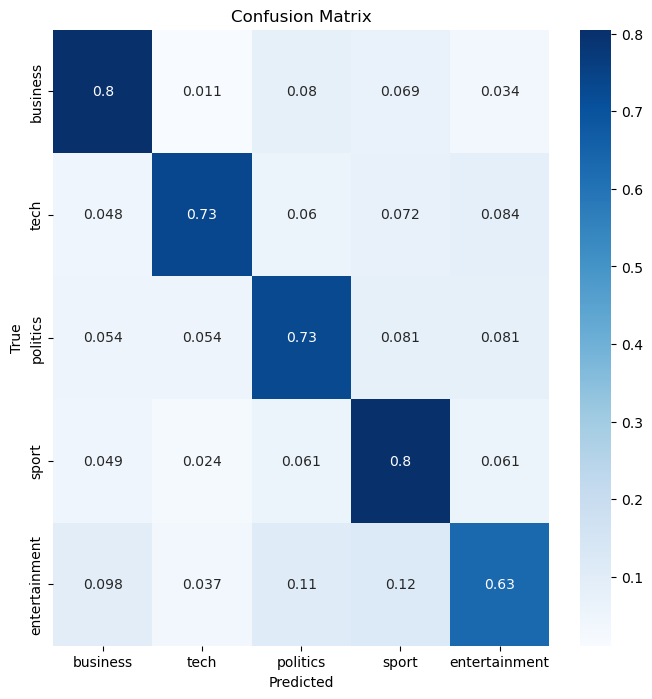

Confusion Matrix for LogisticRegression:


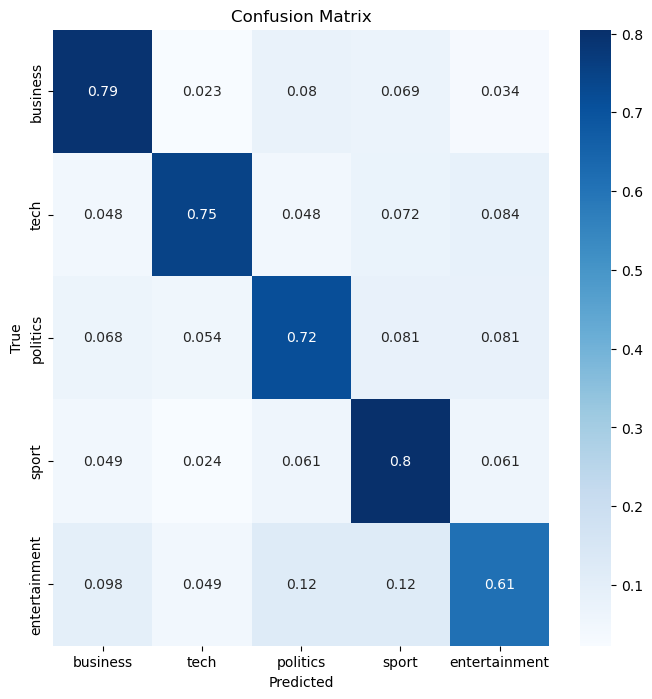

Confusion Matrix for LinearSVC:


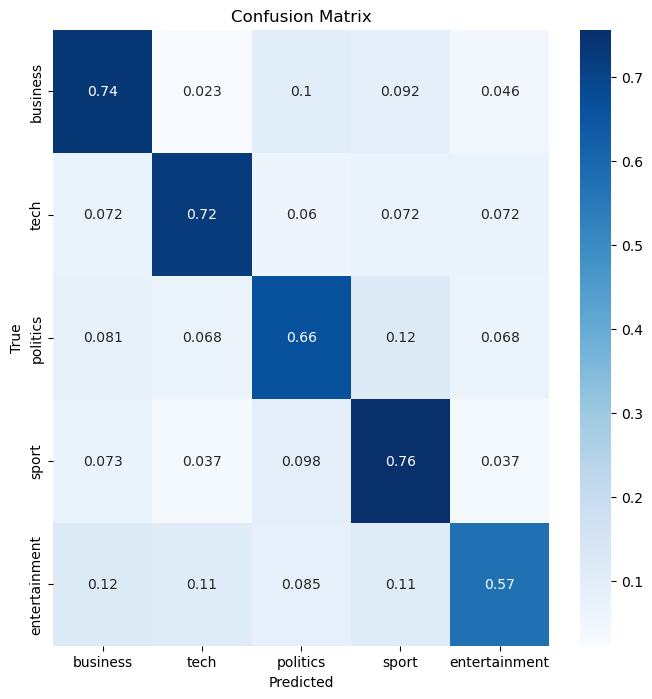

Confusion Matrix for RandomForestClassifier:


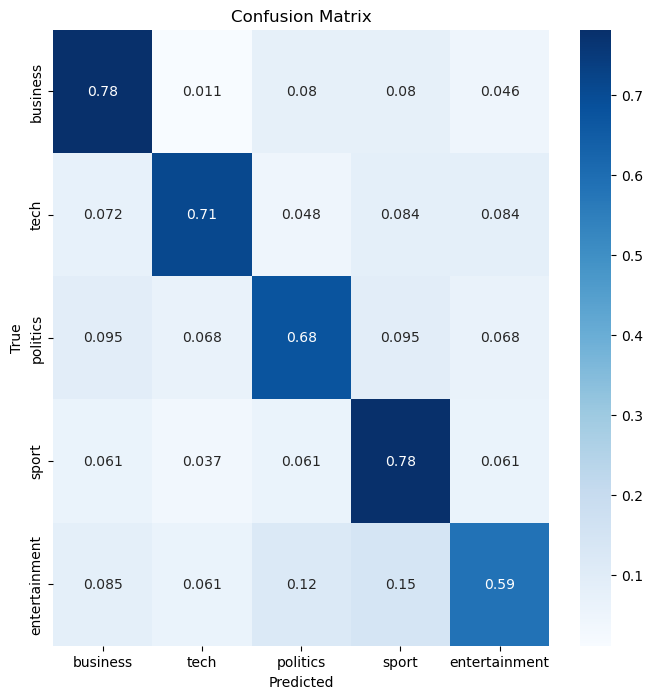

Confusion Matrix for KNeighborsClassifier:


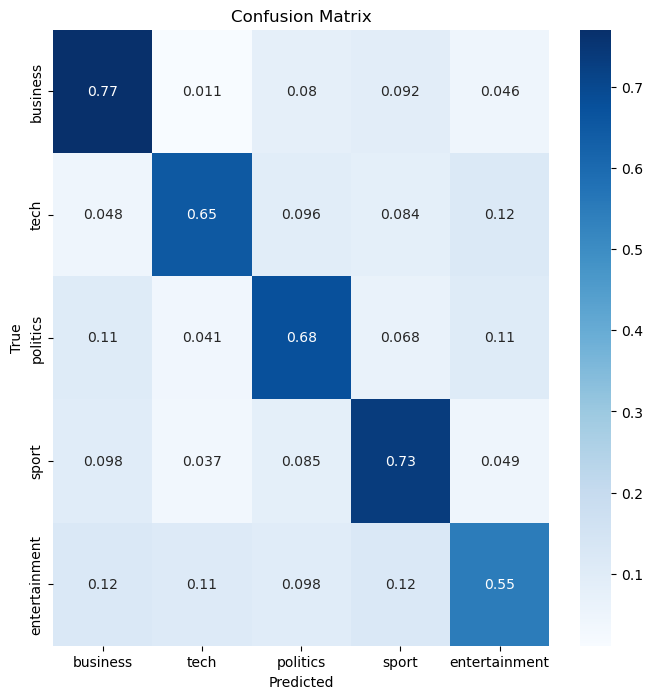

In [30]:
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.metrics import confusion_matrix


def plot_cm(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 8))
    sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

class_names = data['Category'].unique()

for classifier in classifiers:
    classifier.fit(X_train_vec, y_train)
    y_pred = classifier.predict(X_test_vec)
    print(f"Confusion Matrix for {classifier.__class__.__name__}:")
    plot_cm(y_test, y_pred, class_names)




Cosine similarity

In [31]:
category_profiles = {
    # User 1: Sports
    'user1': ["sports", "championship", "soccer", "race", "energy", "football", "tennis", "baseball", "hockey", "basketball", "athletics", "rugby", "swimming", "golf", "cycling", "cricket", "marathon", "gymnastics", "boxing", "volleyball", "badminton", "fencing", "wrestling", "snowboarding", "skiing", "horse-racing", "archery", "table-tennis", "e-sports", "fitness", "olympics"],
    
    # User 2: Business
    'user2': ["business", "finance", "stocks", "economy", "investment", "entrepreneurship", "corporation", "market", "trade", "revenue", "profit", "startup", "loss", "growth", "merger", "acquisition", "tax", "debt", "funding", "venture", "capital", "inflation", "interest", "dividends", "corporate", "strategy", "management", "banking", "insurance", "real-estate", "leasing", "franchise", "supply-chain", "human-resources"],
    
    # User 3: Entertainment
    'user3': ["entertainment", "movies", "music", "television", "celebrities", "awards", "festivals", "box-office", "streaming", "concert", "theater", "comedy", "drama", "action", "romance", "animation", "documentary", "biography", "dance", "art", "literature", "poetry", "photography", "sculpture", "painting", "opera", "ballet", "magic", "circus", "museum", "exhibition", "actor", "actress", "singer", "art", "culture"],
    
    # User 4: Politics
    'user4': ["politics", "government", "elections", "policy", "democracy", "president", "parliament", "vote", "prime-minister", "congress", "senate", "international", "relations", "diplomacy", "referendum", "constitution", "legislation", "political-party", "campaign", "debate", "rights", "protest", "lobbying", "activism", "geopolitics", "foreign-policy", "military", "intelligence", "treaty", "embassy", "visa", "immigration", "trade-agreements"],
    
    # User 5: Tech
    'user5': ["tech", "technology", "innovation", "gadgets", "smartphone", "artificial-intelligence", "robotics", "software", "hardware", "computer", "internet", "cybersecurity", "virtual-reality", "augmented-reality", "machine-learning", "data-science", "blockchain", "cryptocurrency", "internet-of-things", "cloud-computing", "big-data", "quantum-computing", "networking", "operating-system", "mobile-apps", "programming", "research", "drones", "3D-printing", "wearables", "nanotechnology"],
    
    # User 6: Sports + Entertainment
    'user6': ["sports", "football", "rugby", "swimming", "golf", "movies", "music", "television", "celebrities", "awards", "soccer", "athletics", "cricket", "gymnastics", "boxing", "festivals", "box-office", "streaming", "concert", "theater", "basketball", "tennis", "baseball", "hockey", "cycling", "comedy", "drama", "action", "romance", "animation", "documentary", "biography", "dance", "art", "e-sports", "fitness", "literature", "poetry", "photography", "sculpture", "painting"],
    
    # User 7: Business + Tech
    'user7': ["business", "finance", "stocks", "economy", "investment", "tech", "innovation", "gadgets", "smartphone", "artificial-intelligence", "market", "trade", "revenue", "profit", "startup", "robotics", "software", "hardware", "internet", "cybersecurity", "merger", "acquisition", "tax", "debt", "funding", "venture", "capital", "inflation", "interest", "virtual-reality", "augmented-reality", "machine-learning", "data-science", "blockchain", "cryptocurrency", "internet-of-things", "cloud-computing", "big-data", "quantum-computing"],
    
    # User 8: Entertainment + Politics
    'user8': ["entertainment", "movies", "music", "television", "celebrities", "awards", "politics", "government", "elections", "policy", "democracy", "president", "festivals", "box-office", "streaming", "concert", "theater", "parliament", "congress", "senate", "international", "relations", "diplomacy", "referendum", "constitution", "legislation", "comedy", "drama", "action", "romance", "animation", "documentary", "biography", "dance", "art", "political-party", "campaign", "debate", "rights", "protest"],
    
    # User 9: Politics + Tech
    'user9': ["politics", "government", "elections", "policy", "democracy", "president", "tech", "innovation", "gadgets", "smartphone", "artificial-intelligence", "parliament", "congress", "senate", "international", "relations", "diplomacy", "robotics", "software", "hardware", "internet", "cybersecurity", "referendum", "constitution", "legislation", "political-party", "campaign", "debate", "rights", "protest", "virtual-reality", "augmented-reality", "machine-learning", "data-science", "blockchain", "cryptocurrency", "internet-of-things", "cloud-computing", "big-data", "quantum-computing"],
    
    # User 10: Sports + Business + Entertainment
    'user10': ["sports", "football", "rugby", "swimming", "golf", "business", "finance", "stocks", "economy", "investment", "movies", "music", "television", "celebrities", "awards", "soccer", "athletics", "cricket", "gymnastics", "boxing", "market", "trade", "revenue", "profit", "startup", "festivals", "box-office", "streaming", "concert", "theater", "basketball", "tennis", "baseball", "hockey", "cycling", "merger", "acquisition", "tax", "debt", "funding", "venture", "capital", "comedy", "drama", "action", "romance", "animation", "documentary", "biography", "dance", "art"]
}

In [32]:
# Extract top N keywords for each category
def top_n_keywords_by_category(X_train_vec, y_train, vectorizer, n=20):
    categories = y_train.unique()
    feature_names = np.array(vectorizer.get_feature_names_out())
    
    top_keywords = {}
    
    for category in categories:
        category_indices = y_train[y_train == category].index
        category_vectors = X_train_vec[category_indices, :]
        category_sum_vec = np.sum(category_vectors, axis=0)
        
        sorted_indices = np.argsort(category_sum_vec).flatten()[::-1]
        top_n_indices = sorted_indices[:n]
        top_n_keywords = feature_names[top_n_indices]
        
        top_keywords[category] = top_n_keywords.tolist()
    
    return top_keywords

# Test the performance using the keyword profiles
def test_cosine_similarity_with_profiles(text, vectorizer, category_profiles):
    text_vec = vectorizer.transform([text])
    max_similarity = -1
    predicted_category = None

    for category, profile_keywords in category_profiles.items():
        profile_vec = vectorizer.transform([' '.join(map(str, profile_keywords))])
        similarity = cosine_similarity(text_vec, profile_vec)
        if similarity > max_similarity:
            max_similarity = similarity
            predicted_category = category

    return predicted_category

# Create better category profiles
category_profiles = top_n_keywords_by_category(X_train_vec, y_train, vectorizer, n=20)

# Test the performance
y_pred_profiles = [test_cosine_similarity_with_profiles(text, vectorizer, category_profiles) for text in X_test]

# Calculate accuracy and display results
accuracy_profiles = accuracy_score(y_test, y_pred_profiles)
print(f"Accuracy with keyword profiles: {accuracy_profiles:.4f}")

print("Classification Report with keyword profiles:\n", classification_report(y_test, y_pred_profiles))

cm_profiles = confusion_matrix(y_test, y_pred_profiles)
print("Confusion Matrix with keyword profiles:\n", cm_profiles)


Accuracy with keyword profiles: 0.1740
Classification Report with keyword profiles:
                precision    recall  f1-score   support

     business       0.29      0.18      0.23        87
entertainment       0.10      0.06      0.08        83
     politics       0.14      0.35      0.20        74
        sport       0.21      0.12      0.16        82
         tech       0.20      0.17      0.18        82

     accuracy                           0.17       408
    macro avg       0.19      0.18      0.17       408
 weighted avg       0.19      0.17      0.17       408

Confusion Matrix with keyword profiles:
 [[16 13 34 11 13]
 [11  5 47  8 12]
 [ 7 13 26  9 19]
 [ 8 10 42 10 12]
 [13  8 38  9 14]]


In [33]:
# Test the performance using the keyword profiles
y_pred_profiles = [test_cosine_similarity_with_profiles(text, vectorizer, category_profiles) for text in X_test]

# Calculate accuracy and display results
accuracy_profiles = accuracy_score(y_test, y_pred_profiles)
print(f"Accuracy with keyword profiles: {accuracy_profiles:.4f}")

print("Classification Report with keyword profiles:\n", classification_report(y_test, y_pred_profiles))

cm_profiles = confusion_matrix(y_test, y_pred_profiles)
print("Confusion Matrix with keyword profiles:\n", cm_profiles)

Accuracy with keyword profiles: 0.1740
Classification Report with keyword profiles:
                precision    recall  f1-score   support

     business       0.29      0.18      0.23        87
entertainment       0.10      0.06      0.08        83
     politics       0.14      0.35      0.20        74
        sport       0.21      0.12      0.16        82
         tech       0.20      0.17      0.18        82

     accuracy                           0.17       408
    macro avg       0.19      0.18      0.17       408
 weighted avg       0.19      0.17      0.17       408

Confusion Matrix with keyword profiles:
 [[16 13 34 11 13]
 [11  5 47  8 12]
 [ 7 13 26  9 19]
 [ 8 10 42 10 12]
 [13  8 38  9 14]]
